Shameless fitting of series, based on the ideas of http://www.aizac.info/simple-check-of-a-sample-against-80-distributions/

It is based on sample fitting using Kolgomorov-Smirnov tests (http://www.physics.csbsju.edu/stats/KS-test.html) 

In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [26]:
from src import *
from src.models.AlmaClasses import *
palette = PaletteFileDB(filename='../data/processed/colors-almaAntenna.pkl', colorFunction=paintedForAlmaAntennas )
colors=palette.getColors()
db = DelaysFileDB( caseName="CaseAntennaObserving", path= '../' + config.FILEPATH_DB+"/delays") 

%matplotlib inline
from pandas import Series

from matplotlib import pyplot
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats
import math
import random

pyplot.rcParams["figure.figsize"] = (22,6)

In [27]:
# Function to remove possible outliers, up to sigma = 3
def remove_outliers(dataset, sigma=3):
    mean = np.mean(dataset, axis=0)
    sd = np.std(dataset, axis=0)
    return [ x for x in dataset if (x >= mean - 3.0 * sd) and (x <= mean + 3.0 * sd) ]

In [37]:
# Supress some warnings...
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import scipy.stats

# list of all available distributions
cdfs = {
    "alpha": {"p":[], "D": []},           #Alpha
    "anglit": {"p":[], "D": []},          #Anglit
    "arcsine": {"p":[], "D": []},         #Arcsine
    "beta": {"p":[], "D": []},            #Beta
    "betaprime": {"p":[], "D": []},       #Beta Prime
    "bradford": {"p":[], "D": []},        #Bradford
    "burr": {"p":[], "D": []},            #Burr
    "cauchy": {"p":[], "D": []},          #Cauchy
    "chi": {"p":[], "D": []},             #Chi
    "chi2": {"p":[], "D": []},            #Chi-squared
    "cosine": {"p":[], "D": []},          #Cosine
    "dgamma": {"p":[], "D": []},          #Double Gamma
    "dweibull": {"p":[], "D": []},        #Double Weibull
    "erlang": {"p":[], "D": []},          #Erlang
    "expon": {"p":[], "D": []},           #Exponential
    "exponweib": {"p":[], "D": []},       #Exponentiated Weibull
    "exponpow": {"p":[], "D": []},        #Exponential Power
    "f": {"p":[], "D": []},               #F (Snecdor F)
    "fatiguelife": {"p":[], "D": []},     #Fatigue Life (Birnbaum-Sanders)
    "fisk": {"p":[], "D": []},            #Fisk
    #"foldcauchy": {"p":[], "D": []},      #Folded Cauchy
    "foldnorm": {"p":[], "D": []},        #Folded Normal
    "frechet_r": {"p":[], "D": []},       #Frechet Right Sided, Extreme Value Type II
    "frechet_l": {"p":[], "D": []},       #Frechet Left Sided, Weibull_max
    "gamma": {"p":[], "D": []},           #Gamma
    "gausshyper": {"p":[], "D": []},      #Gauss Hypergeometric
    "genexpon": {"p":[], "D": []},        #Generalized Exponential
    "genextreme": {"p":[], "D": []},      #Generalized Extreme Value
    "gengamma": {"p":[], "D": []},        #Generalized gamma
    "genhalflogistic": {"p":[], "D": []}, #Generalized Half Logistic
    "genlogistic": {"p":[], "D": []},     #Generalized Logistic
    "genpareto": {"p":[], "D": []},       #Generalized Pareto
    "gilbrat": {"p":[], "D": []},         #Gilbrat
    "gompertz": {"p":[], "D": []},        #Gompertz (Truncated Gumbel)
    "gumbel_l": {"p":[], "D": []},        #Left Sided Gumbel, etc.
    "gumbel_r": {"p":[], "D": []},        #Right Sided Gumbel
    "halfcauchy": {"p":[], "D": []},      #Half Cauchy
    "halflogistic": {"p":[], "D": []},    #Half Logistic
    "halfnorm": {"p":[], "D": []},        #Half Normal
    "hypsecant": {"p":[], "D": []},       #Hyperbolic Secant
    "invgamma": {"p":[], "D": []},        #Inverse Gamma
    "invgauss": {"p":[], "D": []},        #Inverse Normal
    "invweibull": {"p":[], "D": []},      #Inverse Weibull
    "johnsonsb": {"p":[], "D": []},       #Johnson SB
    "johnsonsu": {"p":[], "D": []},       #Johnson SU
    "laplace": {"p":[], "D": []},         #Laplace
    "logistic": {"p":[], "D": []},        #Logistic
    "loggamma": {"p":[], "D": []},        #Log-Gamma
    #"loglaplace": {"p":[], "D": []},      #Log-Laplace (Log Double Exponential)
    "lognorm": {"p":[], "D": []},         #Log-Normal
    "lomax": {"p":[], "D": []},           #Lomax (Pareto of the second kind)
    "maxwell": {"p":[], "D": []},         #Maxwell
    "mielke": {"p":[], "D": []},          #Mielke's Beta-Kappa
    "nakagami": {"p":[], "D": []},        #Nakagami
    "ncx2": {"p":[], "D": []},            #Non-central chi-squared
    "ncf": {"p":[], "D": []},             #Non-central F
    "nct": {"p":[], "D": []},             #Non-central Student's T
    "norm": {"p":[], "D": []},            #Normal (Gaussian)
    "pareto": {"p":[], "D": []},          #Pareto
    "pearson3": {"p":[], "D": []},        #Pearson type III
    "powerlaw": {"p":[], "D": []},        #Power-function
    "powerlognorm": {"p":[], "D": []},    #Power log normal
    "powernorm": {"p":[], "D": []},       #Power normal
    "rdist": {"p":[], "D": []},           #R distribution
    "reciprocal": {"p":[], "D": []},      #Reciprocal
    "rayleigh": {"p":[], "D": []},        #Rayleigh
    "rice": {"p":[], "D": []},            #Rice
    "recipinvgauss": {"p":[], "D": []},   #Reciprocal Inverse Gaussian
    "semicircular": {"p":[], "D": []},    #Semicircular
    "t": {"p":[], "D": []},               #Student's T
    "triang": {"p":[], "D": []},          #Triangular
    "truncexpon": {"p":[], "D": []},      #Truncated Exponential
    "truncnorm": {"p":[], "D": []},       #Truncated Normal
    "tukeylambda": {"p":[], "D": []},     #Tukey-Lambda
    "uniform": {"p":[], "D": []},         #Uniform
    "vonmises": {"p":[], "D": []},        #Von-Mises (Circular)
    "wald": {"p":[], "D": []},            #Wald
    "weibull_min": {"p":[], "D": []},     #Minimum Weibull (see Frechet)
    "weibull_max": {"p":[], "D": []},     #Maximum Weibull (see Frechet)
    "wrapcauchy": {"p":[], "D": []},      #Wrapped Cauchy
    "ksone": {"p":[], "D": []},           #Kolmogorov-Smirnov one-sided (no stats)
    "kstwobign": {"p":[], "D": []}}       #Kolmogorov-Smirnov two-sided test for Large N


def check(data, fct, verbose=False):
    #fit our data set against every probability distribution
    parameters = eval("scipy.stats."+fct+".fit(data)");
    #Applying the Kolmogorov-Smirnof two sided test
    D, p = scipy.stats.kstest(data, fct, args=parameters);

    if math.isnan(p): p=0
    if math.isnan(D): D=0

    if verbose:
        print(fct.ljust(16) + "p: " + str(p).ljust(25) + "D: " +str(D))

    return (fct, p, D)

def plot(fcts, data):
    # plot data
    plt.hist(data, normed=True, bins=max(10, len(data)/10))

    # plot fitted probability
    for fct in fcts:
        params = eval("scipy.stats."+fct+".fit(data)")
        f = eval("scipy.stats."+fct+".freeze"+str(params))
        x = np.linspace(f.ppf(0.001), f.ppf(0.999), 500)
        plt.plot(x, f.pdf(x), lw=3, label=fct)
    plt.legend(loc='best', frameon=False)
    plt.title("Top "+str(len(fcts))+" Results")
    plt.show()

def plotDensities(best):
    plt.ion()
    plt.clf()
    # plot fitted probability
    for i in range(len(best)-1, -1, -1):
        fct, values = best[i]
        plt.hist(values["p"], normed=True, bins=max(10, len(values["p"])/10), label=str(i+1)+". "+fct, alpha=0.5)
    plt.legend(loc='best', frameon=False)
    plt.title("Top Results")
    plt.show()
    plt.draw()

def compare_everything( rawdata, iterations=10 ):
    cds = cdfs.copy()
    for fct in cds.keys():
        for i in range(iterations):
            DATA = [ x for x in rawdata if random.random()>=0.75 ]
            key, p, D = check(DATA, fct, False)
            cds[key]["p"].append(p)
            cds[key]["D"].append(D)

    best = sorted(cds.items(), key=lambda elem : scipy.median(elem[1]["p"]), reverse=True)
    return best

def show_fitting(best, rawdata):
    print( "-------------------------------------------------------------------" )
    print( "Top 10 after %d iteration(s)" % ( 1 ) )
    print( "-------------------------------------------------------------------" )

    for t in range(10):
        fct, values = best[t]
        print str(t+1).ljust(4), fct.ljust(16), "\tp: %.5f" % scipy.median(values["p"]), "\tD: %.5f" %  scipy.median(values["D"]), 
        if len(values["p"]) > 1:
            print "\tvar(p): %.5f" % scipy.var(values["p"]), "\tvar(D): %.5f" % scipy.var(values["D"])

    plot([b[0] for b in best[:5]], rawdata)
    plotDensities(best[:5])
    

In [29]:
# (a,b) = (464, 469) # NADA!!
# (a,b) = (464, 484)  # T-students, or johnsonsu
# (a,b) = (465, 476)  # johnsonsu

rawdata_464_469 = remove_outliers( db.getDelays(464, 469) )
best_464_469 = compare_everything( rawdata_464_469 )

-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    f                	p: 0.00000 	D: 0.20923 	var(p): 0.00000 	var(D): 0.00014
2    invgamma         	p: 0.00000 	D: 0.21722 	var(p): 0.00000 	var(D): 0.00003
3    invgauss         	p: 0.00000 	D: 0.21298 	var(p): 0.00000 	var(D): 0.00015
4    genextreme       	p: 0.00000 	D: 0.21936 	var(p): 0.00000 	var(D): 0.00007
5    alpha            	p: 0.00000 	D: 0.21871 	var(p): 0.00000 	var(D): 0.00010
6    mielke           	p: 0.00000 	D: 0.22883 	var(p): 0.00000 	var(D): 0.00366
7    genpareto        	p: 0.00000 	D: 0.21779 	var(p): 0.00000 	var(D): 0.00575
8    invweibull       	p: 0.00000 	D: 0.22799 	var(p): 0.00000 	var(D): 0.00014
9    lomax            	p: 0.00000 	D: 0.23506 	var(p): 0.00000 	var(D): 0.02722
10   burr             	p: 0.00000 	D: 0.23995 	var(p): 0.00000 	var(D): 0.00306


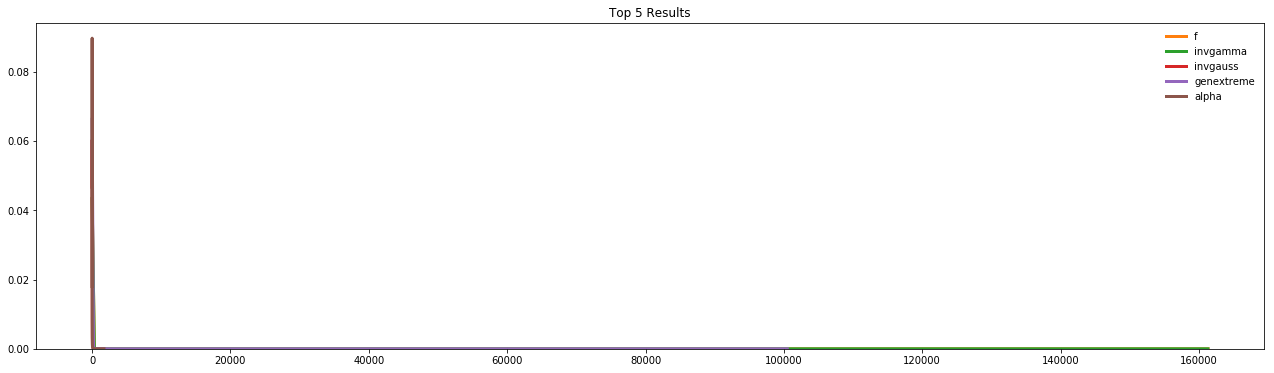

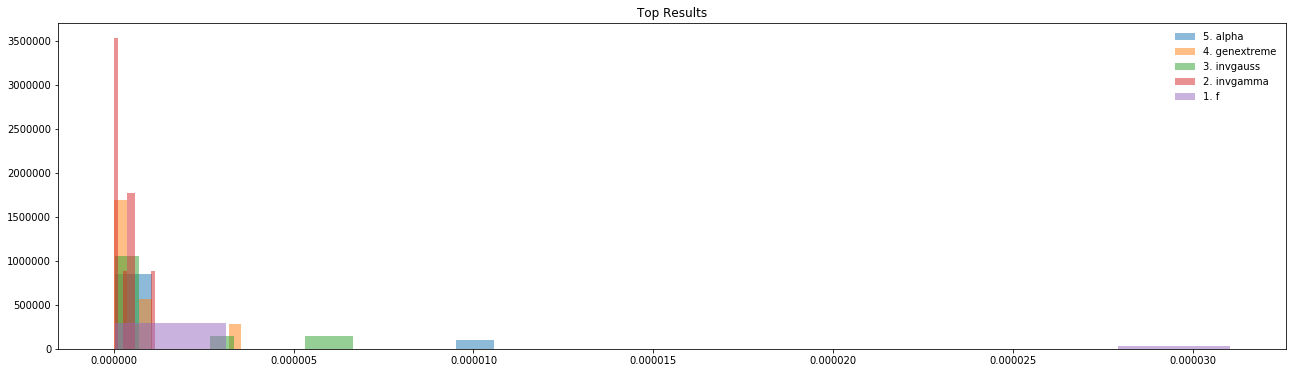

<Figure size 1584x432 with 0 Axes>

In [30]:
show_fitting(best_464_469, rawdata_464_469)

In [42]:
rawdata_464_484 = remove_outliers( db.getDelays(464, 484) )
best_464_484 = compare_everything( rawdata_464_484 )

/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2691: RuntimeWarning: divide by zero encountered in power
  tmp0 = tmp**(limit-1)
/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2692: RuntimeWarning: invalid value encountered in multiply
  tmp2 = tmp0*tmp
/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:4765: RuntimeWarning: overflow encountered in multiply
  trm1 /= np.asarray(fac1*sc.gamma((n+1)/2))
/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:4767: RuntimeWarning: overflow encountered in multiply
  trm2 /= np.asarray(np.sqrt(fac1)*sc.gamma(n/2+1))


-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.80174 	D: 0.07133 	var(p): 0.02545 	var(D): 0.00016
2    t                	p: 0.25933 	D: 0.11109 	var(p): 0.08103 	var(D): 0.00084
3    fisk             	p: 0.16802 	D: 0.11938 	var(p): 0.02684 	var(D): 0.00038
4    cauchy           	p: 0.16045 	D: 0.11732 	var(p): 0.08950 	var(D): 0.00111
5    laplace          	p: 0.15704 	D: 0.12149 	var(p): 0.06800 	var(D): 0.00136
6    genlogistic      	p: 0.15112 	D: 0.12723 	var(p): 0.03126 	var(D): 0.00046
7    hypsecant        	p: 0.14362 	D: 0.12572 	var(p): 0.07291 	var(D): 0.00095
8    tukeylambda      	p: 0.11986 	D: 0.12607 	var(p): 0.09613 	var(D): 0.00761
9    dgamma           	p: 0.10286 	D: 0.12783 	var(p): 0.07347 	var(D): 0.00166
10   dweibull         	p: 0.08869 	D: 0.13153 	var(p): 0.05289 	var(D): 0.00186


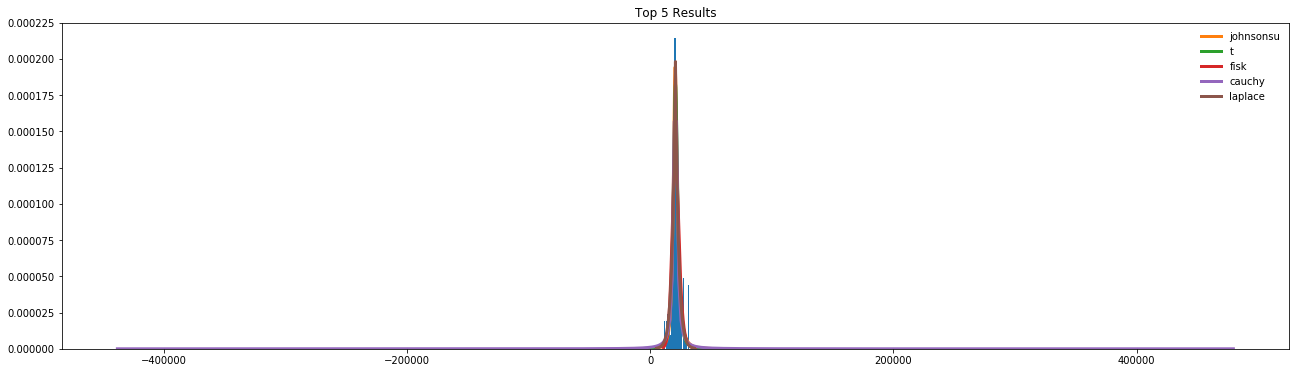

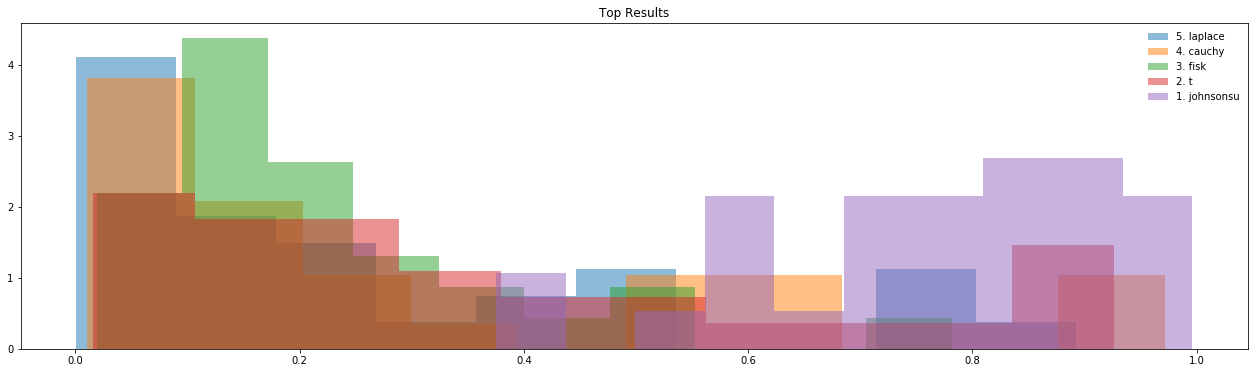

<Figure size 1584x432 with 0 Axes>

In [43]:
show_fitting(best_464_484, rawdata_464_484)

In [40]:
rawdata_465_476 = remove_outliers( db.getDelays(465, 476) )
best_465_476 = compare_everything( rawdata_465_476 )

-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.76701 	D: 0.07257 	var(p): 0.02485 	var(D): 0.00013
2    t                	p: 0.17801 	D: 0.11978 	var(p): 0.01813 	var(D): 0.00046
3    fisk             	p: 0.14164 	D: 0.12278 	var(p): 0.00852 	var(D): 0.00026
4    laplace          	p: 0.09393 	D: 0.13685 	var(p): 0.01910 	var(D): 0.00106
5    hypsecant        	p: 0.08836 	D: 0.13231 	var(p): 0.04186 	var(D): 0.00061
6    cauchy           	p: 0.08755 	D: 0.13328 	var(p): 0.00760 	var(D): 0.00043
7    genlogistic      	p: 0.08746 	D: 0.13333 	var(p): 0.00751 	var(D): 0.00028
8    tukeylambda      	p: 0.05737 	D: 0.14108 	var(p): 0.02013 	var(D): 0.00685
9    dgamma           	p: 0.04643 	D: 0.14712 	var(p): 0.01408 	var(D): 0.00098
10   logistic         	p: 0.04355 	D: 0.14349 	var(p): 0.00224 	var(D): 0.00021


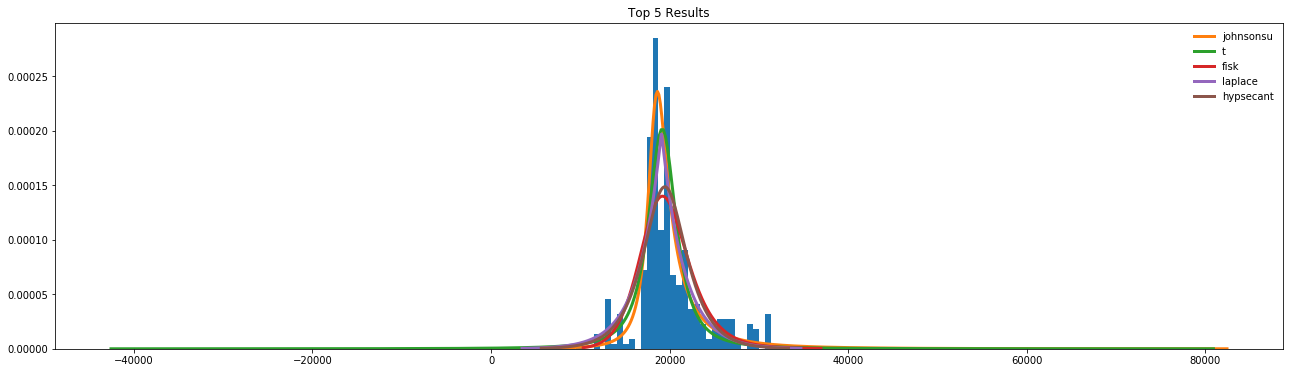

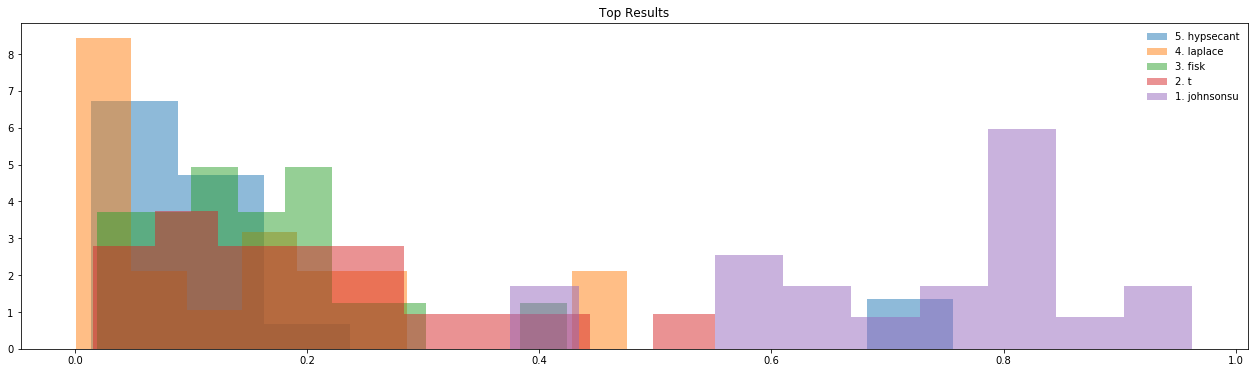

<Figure size 1584x432 with 0 Axes>

In [41]:
show_fitting(best_465_476, rawdata_465_476)

In [38]:
rawdata = remove_outliers( db.getDelays(464, 482) )
best = compare_everything( rawdata )

-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.66147 	D: 0.07896 	var(p): 0.01770 	var(D): 0.00011
2    hypsecant        	p: 0.14034 	D: 0.12572 	var(p): 0.07090 	var(D): 0.00094
3    t                	p: 0.13780 	D: 0.12948 	var(p): 0.01279 	var(D): 0.00036
4    fisk             	p: 0.12480 	D: 0.12100 	var(p): 0.01181 	var(D): 0.00025
5    tukeylambda      	p: 0.09865 	D: 0.13199 	var(p): 0.01828 	var(D): 0.00627
6    genlogistic      	p: 0.08746 	D: 0.13333 	var(p): 0.00422 	var(D): 0.00022
7    cauchy           	p: 0.07985 	D: 0.13738 	var(p): 0.00850 	var(D): 0.00042
8    dgamma           	p: 0.07634 	D: 0.13914 	var(p): 0.01100 	var(D): 0.00091
9    logistic         	p: 0.06161 	D: 0.13285 	var(p): 0.00317 	var(D): 0.00029
10   alpha            	p: 0.06108 	D: 0.14494 	var(p): 0.00343 	var(D): 0.00038


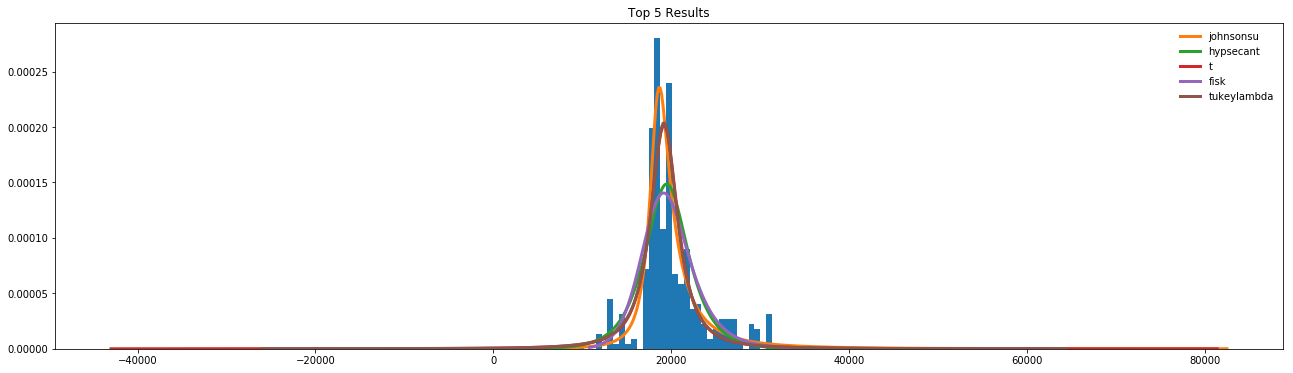

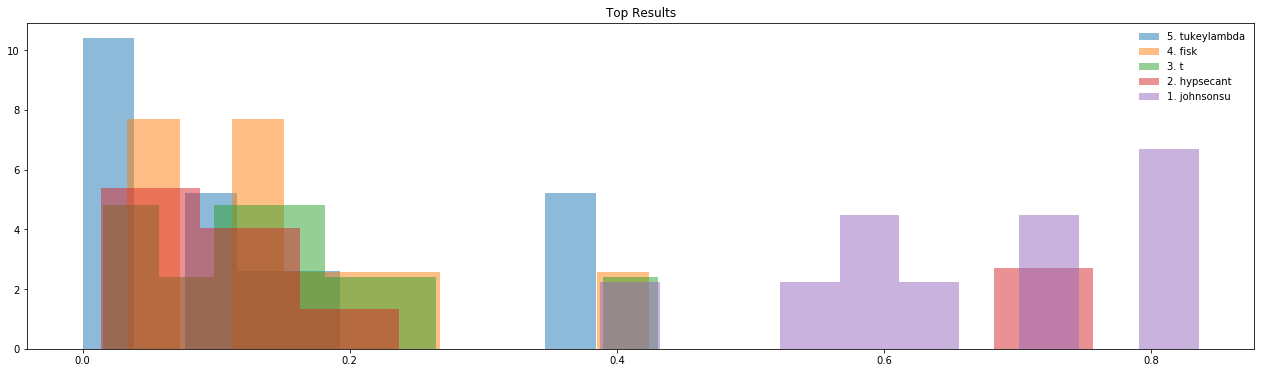

<Figure size 1584x432 with 0 Axes>

In [39]:
show_fitting(best, rawdata)

## Same analysis for some other types of datasets

Analyzing pair (465, 469)


/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:5477: RuntimeWarning: divide by zero encountered in true_divide
  return -(1-mu*x)**2.0 / (2*x*mu**2.0) - 0.5*np.log(2*np.pi*x)
/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:5477: RuntimeWarning: divide by zero encountered in log
  return -(1-mu*x)**2.0 / (2*x*mu**2.0) - 0.5*np.log(2*np.pi*x)
/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:5477: RuntimeWarning: invalid value encountered in subtract
  return -(1-mu*x)**2.0 / (2*x*mu**2.0) - 0.5*np.log(2*np.pi*x)


-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.72086 	D: 0.07594 	var(p): 0.12885 	var(D): 0.04664
2    t                	p: 0.17801 	D: 0.11978 	var(p): 0.08535 	var(D): 0.02433
3    fisk             	p: 0.12369 	D: 0.12818 	var(p): 0.02886 	var(D): 0.01000
4    hypsecant        	p: 0.08836 	D: 0.13231 	var(p): 0.06956 	var(D): 0.01269
5    cauchy           	p: 0.08755 	D: 0.13328 	var(p): 0.08326 	var(D): 0.00772
6    genlogistic      	p: 0.08746 	D: 0.13333 	var(p): 0.03068 	var(D): 0.01441
7    laplace          	p: 0.06816 	D: 0.13902 	var(p): 0.06303 	var(D): 0.02341
8    dgamma           	p: 0.04643 	D: 0.14712 	var(p): 0.06621 	var(D): 0.01331
9    logistic         	p: 0.04355 	D: 0.14349 	var(p): 0.02124 	var(D): 0.00988
10   tukeylambda      	p: 0.04344 	D: 0.14402 	var(p): 0.08726 	var(D): 0.04682


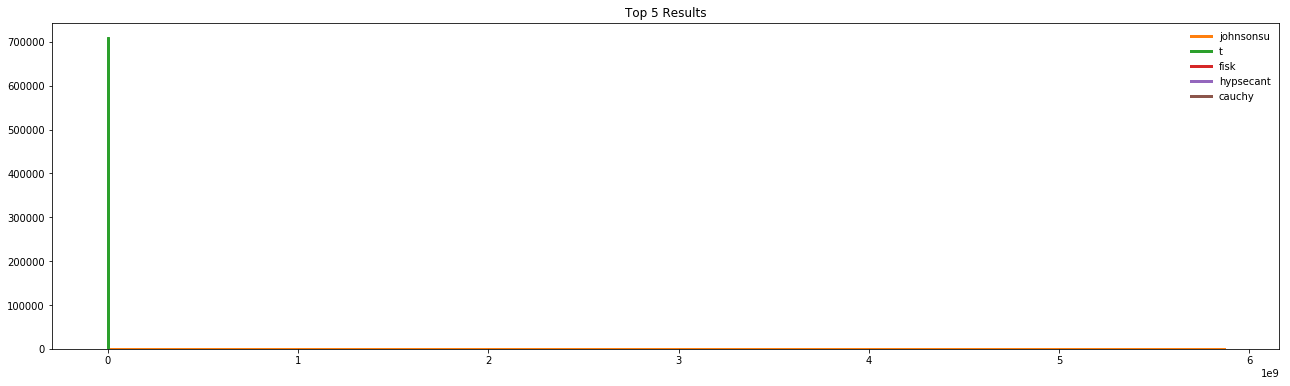

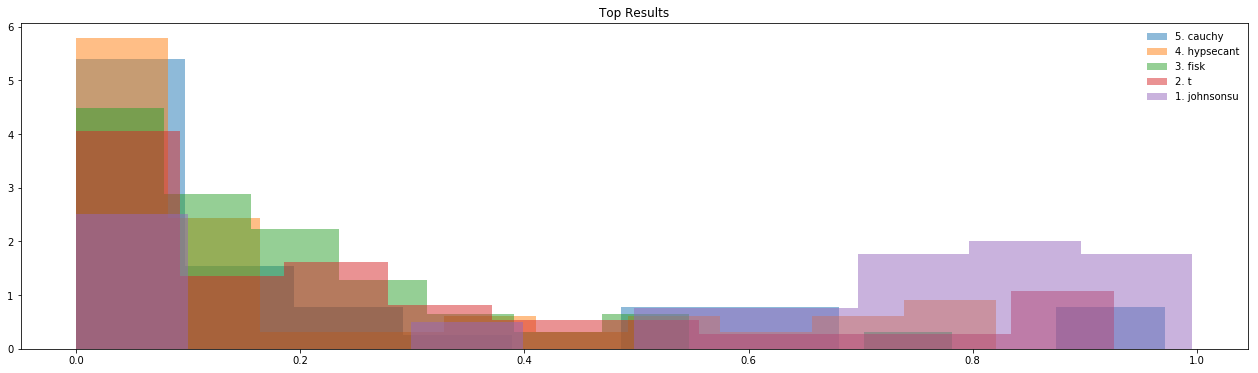

Analyzing pair (511, 512)
-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.59666 	D: 0.08465 	var(p): 0.15414 	var(D): 0.03739
2    t                	p: 0.09712 	D: 0.13389 	var(p): 0.08007 	var(D): 0.02476
3    fisk             	p: 0.09399 	D: 0.13795 	var(p): 0.02729 	var(D): 0.01103
4    genlogistic      	p: 0.05384 	D: 0.14474 	var(p): 0.02802 	var(D): 0.01484
5    hypsecant        	p: 0.03748 	D: 0.15870 	var(p): 0.06279 	var(D): 0.01283
6    cauchy           	p: 0.03449 	D: 0.15469 	var(p): 0.07435 	var(D): 0.01053
7    logistic         	p: 0.02598 	D: 0.15298 	var(p): 0.01918 	var(D): 0.01069
8    betaprime        	p: 0.02105 	D: 0.16594 	var(p): 0.00839 	var(D): 0.00649
9    laplace          	p: 0.01966 	D: 0.15783 	var(p): 0.05620 	var(D): 0.02424
10   f                	p: 0.01407 	D: 0.17015 	var(p): 0.00639 	var(D): 0.00513


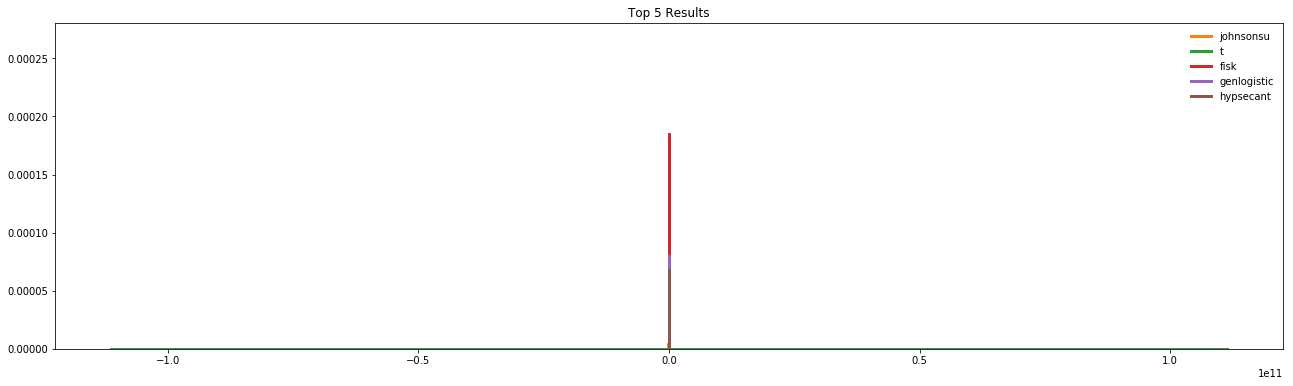

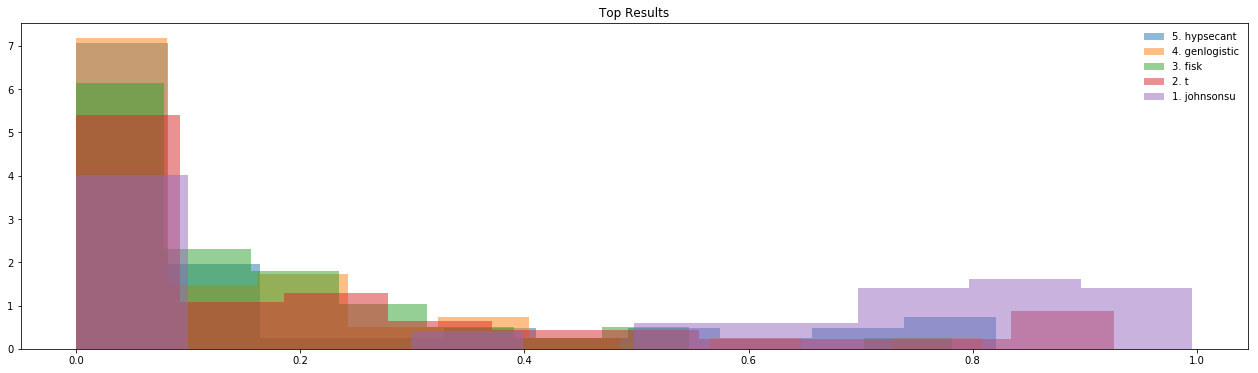

Analyzing pair (501, 505)
-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.20305 	D: 0.10301 	var(p): 0.15789 	var(D): 0.03159
2    logistic         	p: 0.01072 	D: 0.14918 	var(p): 0.01720 	var(D): 0.00962
3    fisk             	p: 0.01061 	D: 0.13459 	var(p): 0.02507 	var(D): 0.00971
4    t                	p: 0.00814 	D: 0.13909 	var(p): 0.07328 	var(D): 0.02163
5    genlogistic      	p: 0.00765 	D: 0.14273 	var(p): 0.02528 	var(D): 0.01325
6    hypsecant        	p: 0.00714 	D: 0.14520 	var(p): 0.05629 	var(D): 0.01139
7    cauchy           	p: 0.00525 	D: 0.17070 	var(p): 0.06626 	var(D): 0.00885
8    johnsonsb        	p: 0.00461 	D: 0.15756 	var(p): 0.00351 	var(D): 0.00474
9    nct              	p: 0.00421 	D: 0.17870 	var(p): 0.00362 	var(D): 0.00861
10   betaprime        	p: 0.00383 	D: 0.17593 	var(p): 0.00740 	var(D): 0.00547


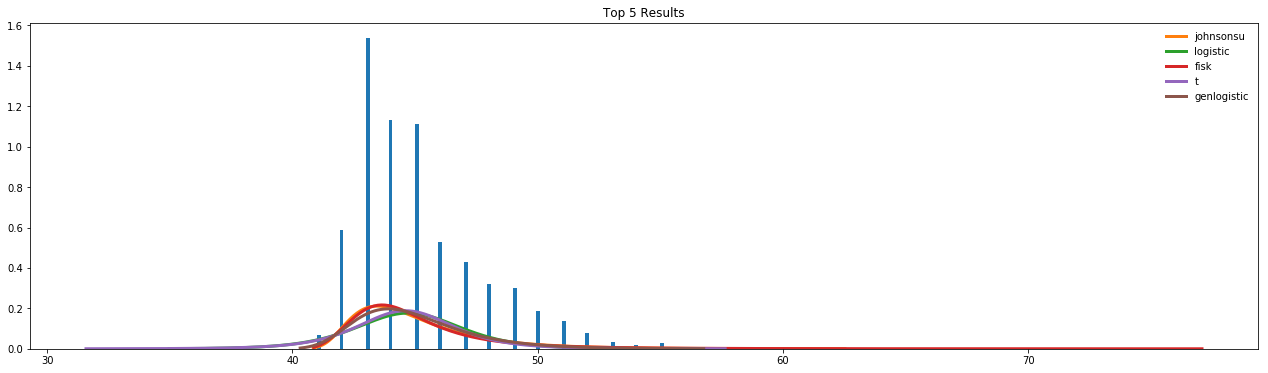

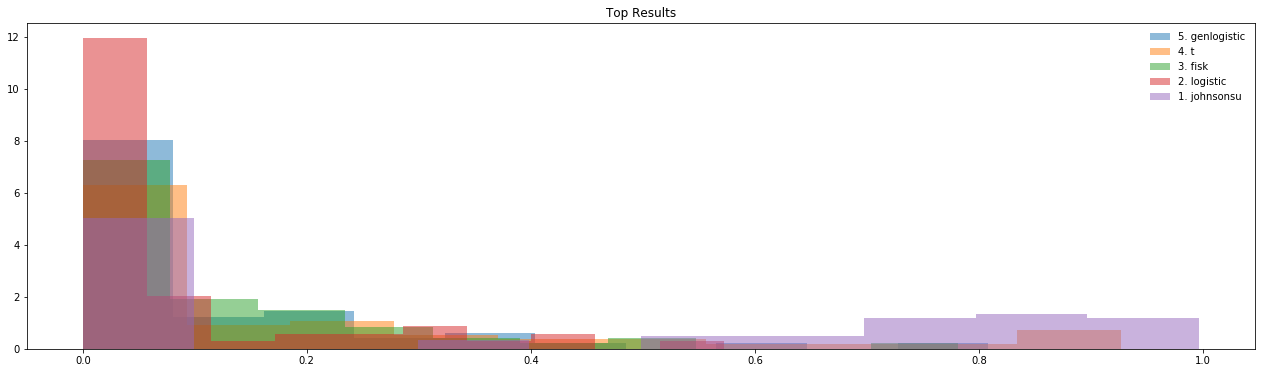

Analyzing pair (473, 477)
-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.01524 	D: 0.13345 	var(p): 0.15265 	var(D): 0.03407
2    t                	p: 0.00079 	D: 0.15204 	var(p): 0.06677 	var(D): 0.01896
3    invweibull       	p: 0.00044 	D: 0.18429 	var(p): 0.00044 	var(D): 0.00706
4    alpha            	p: 0.00042 	D: 0.17667 	var(p): 0.00277 	var(D): 0.00244
5    invgamma         	p: 0.00042 	D: 0.18782 	var(p): 0.00960 	var(D): 0.00297
6    f                	p: 0.00039 	D: 0.19497 	var(p): 0.00499 	var(D): 0.00457
7    johnsonsb        	p: 0.00023 	D: 0.17075 	var(p): 0.00314 	var(D): 0.00596
8    fisk             	p: 0.00016 	D: 0.14242 	var(p): 0.02292 	var(D): 0.01264
9    burr             	p: 0.00010 	D: 0.21565 	var(p): 0.00048 	var(D): 0.00484
10   beta             	p: 0.00008 	D: 0.19253 	var(p): 0.00361 	var(D): 0.01912


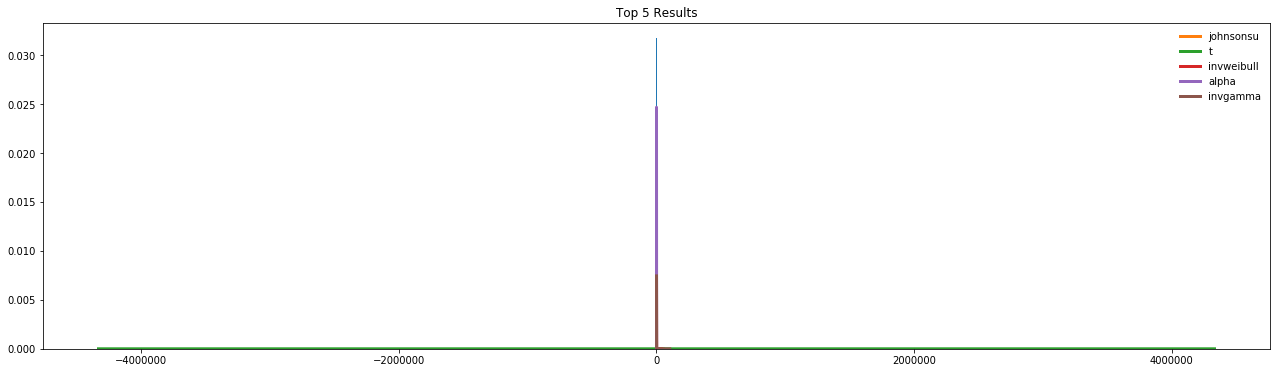

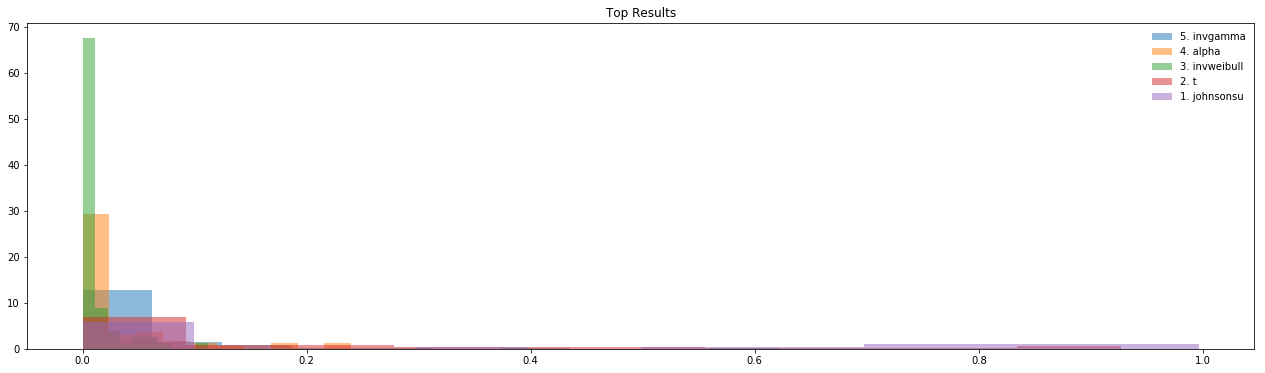

Analyzing pair (474, 480)
-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.02047 	D: 0.14240 	var(p): 0.14246 	var(D): 0.03004
2    invgamma         	p: 0.00429 	D: 0.17493 	var(p): 0.00850 	var(D): 0.00281
3    f                	p: 0.00243 	D: 0.17568 	var(p): 0.00481 	var(D): 0.00435
4    invweibull       	p: 0.00134 	D: 0.18258 	var(p): 0.00066 	var(D): 0.00666
5    fisk             	p: 0.00052 	D: 0.14912 	var(p): 0.02066 	var(D): 0.01247
6    johnsonsb        	p: 0.00049 	D: 0.18393 	var(p): 0.00282 	var(D): 0.00574
7    alpha            	p: 0.00039 	D: 0.18885 	var(p): 0.00250 	var(D): 0.00241
8    t                	p: 0.00029 	D: 0.17752 	var(p): 0.06105 	var(D): 0.01681
9    burr             	p: 0.00009 	D: 0.22810 	var(p): 0.00062 	var(D): 0.00484
10   beta             	p: 0.00008 	D: 0.22167 	var(p): 0.00326 	var(D): 0.01698


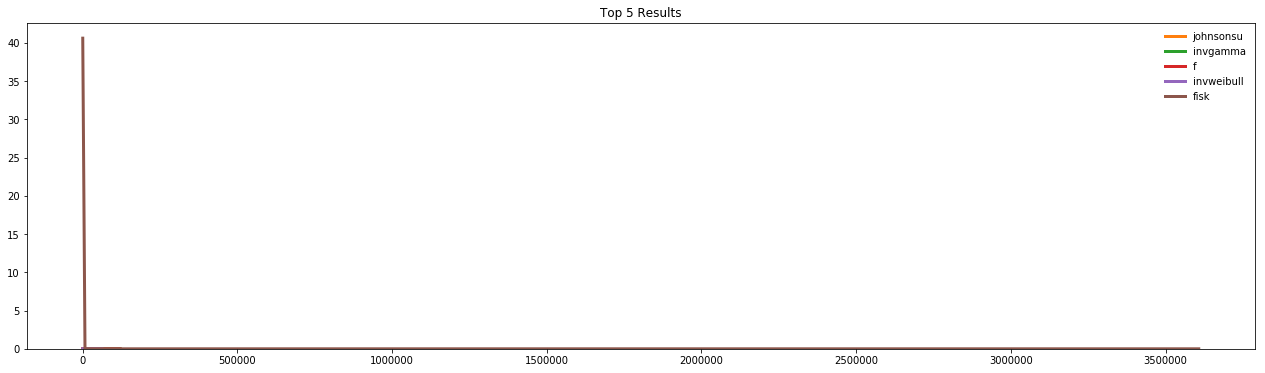

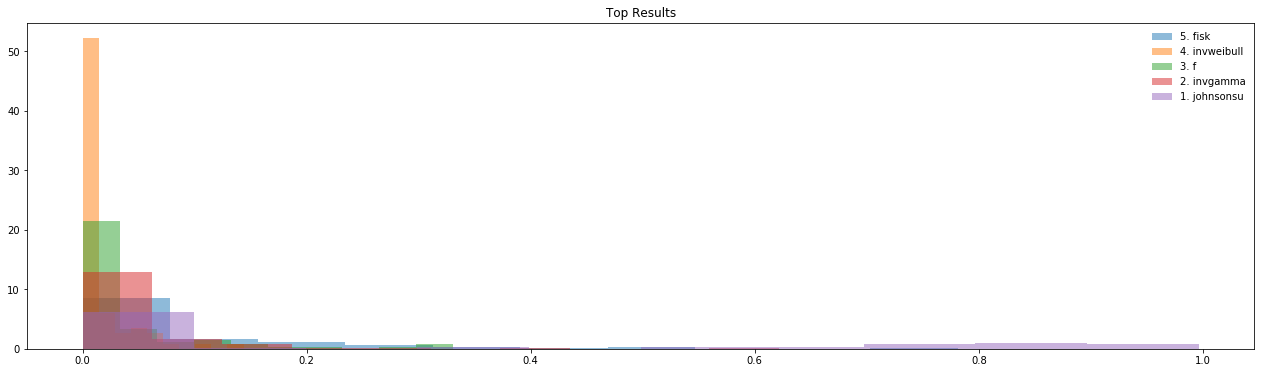

Analyzing pair (480, 484)


/home/juanpablo/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2276: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


-------------------------------------------------------------------
Top 10 after 1 iteration(s)
-------------------------------------------------------------------
1    johnsonsu        	p: 0.01327 	D: 0.15263 	var(p): 0.13521 	var(D): 0.02726
2    invgamma         	p: 0.00042 	D: 0.18782 	var(p): 0.00774 	var(D): 0.00452
3    f                	p: 0.00039 	D: 0.19711 	var(p): 0.00441 	var(D): 0.00591
4    alpha            	p: 0.00033 	D: 0.20292 	var(p): 0.00229 	var(D): 0.01352
5    invweibull       	p: 0.00028 	D: 0.18645 	var(p): 0.00061 	var(D): 0.00743
6    johnsonsb        	p: 0.00021 	D: 0.20790 	var(p): 0.00257 	var(D): 0.00603
7    fisk             	p: 0.00011 	D: 0.17479 	var(p): 0.01907 	var(D): 0.01209
8    t                	p: 0.00008 	D: 0.21794 	var(p): 0.05609 	var(D): 0.01722
9    burr             	p: 0.00004 	D: 0.23523 	var(p): 0.00055 	var(D): 0.00583
10   beta             	p: 0.00003 	D: 0.24298 	var(p): 0.00297 	var(D): 0.01904


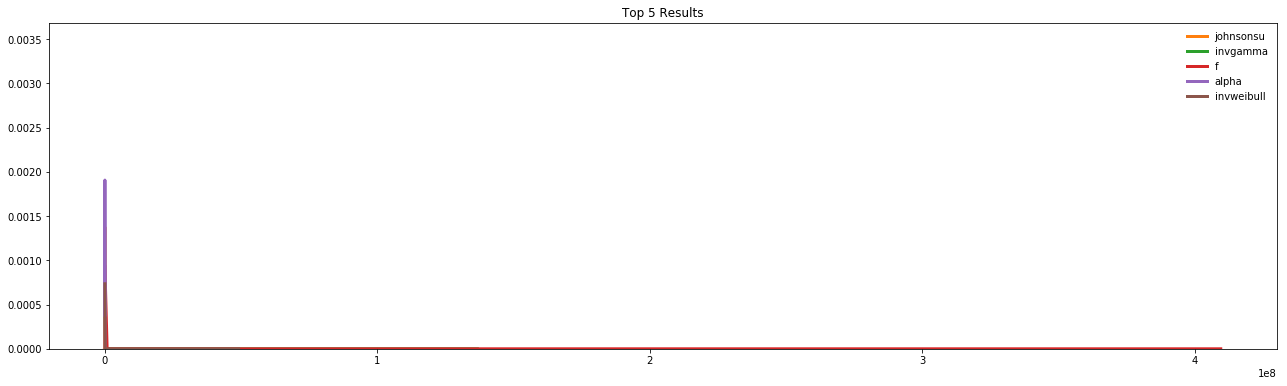

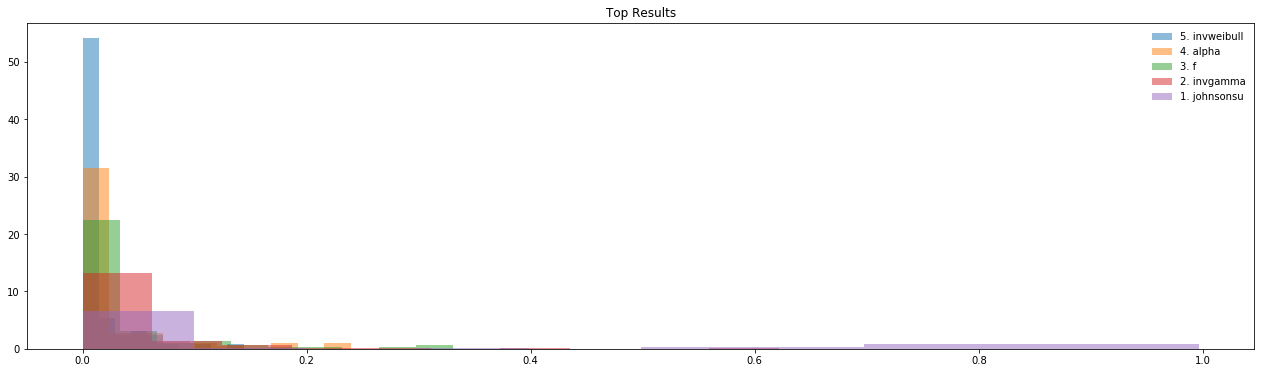

<Figure size 1584x432 with 0 Axes>

In [44]:
for (a,b) in [(465, 469), (511, 512), (501, 505), (473, 477), (474, 480), (480, 484) ]:
    print "Analyzing pair (%s, %s)" % (a,b)
    rawdata = remove_outliers( db.getDelays(a,b) )
    best = compare_everything( rawdata )
    show_fitting(best, rawdata)
    